In this project, i will be performing unsupervised clustering of data of customer records for the competition **tathya 2023.**

Importing libraries

In [1]:
import math,copy
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

Loading the data

In [2]:
data=pd.read_csv('/kaggle/input/tathya-2023/Round_2_Dataset.csv')
print('number of datapoints : ', len(data))
data.head()

number of datapoints :  1000


,Customer ID,Age,Income,Gender,Region,Product Category,Purchase Frequency,Last Purchase Amount,Customer Satisfaction,Purchase Date
0,79,36,5207.0,Other,West,Clothing,5,20.09,1.1,23-01-2021 03:13
1,18,56,5478.0,Other,North,Groceries,9,21.32,8.5,02-09-2021 13:56
2,740,51,7489.0,Male,East,Electronics,1,21.54,8.9,15-01-2021 08:31
3,504,67,6612.0,Female,West,Clothing,13,22.16,1.9,15-12-2021 00:24
4,912,66,4334.0,Female,South,Groceries,8,22.26,5.9,11-02-2021 04:32


**Data Cleaning**.
The dataset contains missing values. For clustering, i will simply remove the rows containing missing values.

In [3]:
data.info

<bound method DataFrame.info of      Customer ID  Age  Income  Gender Region Product Category  \
0             79   36  5207.0   Other   West         Clothing   
1             18   56  5478.0   Other  North        Groceries   
2            740   51  7489.0    Male   East      Electronics   
3            504   67  6612.0  Female   West         Clothing   
4            912   66  4334.0  Female  South        Groceries   
..           ...  ...     ...     ...    ...              ...   
995          917   47  7949.0   Other  South         Clothing   
996          938   47  8155.0  Female  South    Home & Living   
997          947   27  9459.0   Other   East         Clothing   
998          966   40  9054.0    Male  South    Home & Living   
999          973   68  6199.0   Other   West         Clothing   

     Purchase Frequency  Last Purchase Amount  Customer Satisfaction  \
0                     5                 20.09                    1.1   
1                     9                 21.

There are some missing values in Income and Last purchase amount. For this, i will be simply removing those rows.

In [4]:
data=data.dropna()
print("the number of datapoints after dropping those rows :", len(data))

the number of datapoints after dropping those rows : 902


**Feature engineering.**
* Exploring unique values in categorical features to get a clear idea of the data

In [5]:
print(print("Total categories in the feature Gender:\n", data["Gender"].value_counts(), "\n"))
print("Total categories in the feature Region:\n", data["Region"].value_counts(), "\n")
print("Total categories in the feature Product Category:\n", data["Product Category"].value_counts(), "\n")

Total categories in the feature Gender:
 Gender
Female    303
Male      302
Other     297
Name: count, dtype: int64 

None
Total categories in the feature Region:
 Region
West     239
South    233
North    220
East     210
Name: count, dtype: int64 

Total categories in the feature Product Category:
 Product Category
Groceries        195
Sports           187
Electronics      182
Home & Living    171
Clothing         167
Name: count, dtype: int64 



In [6]:
data.describe()

,Customer ID,Age,Income,Purchase Frequency,Last Purchase Amount,Customer Satisfaction
count,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000
mean,500.079823,43.577605,6056.064302,7.733925,287.418359,5.576275
std,288.876515,15.110032,7869.605626,4.054039,310.598122,2.591160
min,1.000000,18.000000,1035.000000,1.000000,20.090000,1.000000
25%,249.250000,30.000000,3144.500000,4.000000,143.395000,3.400000
50%,495.500000,44.000000,5208.500000,8.000000,261.780000,5.700000
75%,747.750000,56.000000,7470.000000,11.000000,386.035000,7.875000
max,1000.000000,69.000000,95190.000000,14.000000,4675.700000,10.000000


Mean income and max income and last purchase amount (mean) and it's max show discrepancy. **Thus, indicating the presence of outliers.**

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 800x550 with 0 Axes>

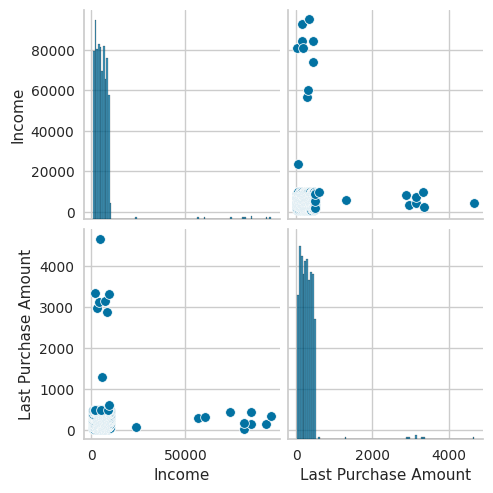

In [7]:
To_plot=["Income","Last Purchase Amount"]
plt.figure()
sns.pairplot(data[To_plot])
plt.show

Deleting these outliers in the data

In [8]:
data = data[(data["Income"]<10000)]
data = data[(data["Last Purchase Amount"]<1000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 884


In [9]:
data.describe()

,Customer ID,Age,Income,Purchase Frequency,Last Purchase Amount,Customer Satisfaction
count,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000
mean,500.903846,43.661765,5296.969457,7.740950,262.525317,5.580090
std,289.161103,15.060763,2555.839838,4.053951,139.011925,2.591499
min,1.000000,18.000000,1035.000000,1.000000,20.090000,1.000000
25%,252.750000,30.750000,3127.000000,4.000000,143.070000,3.400000
50%,495.500000,44.000000,5159.500000,8.000000,260.815000,5.700000
75%,749.250000,56.000000,7430.500000,11.000000,383.612500,7.900000
max,1000.000000,69.000000,9993.000000,14.000000,603.200000,10.000000


Standard deviation has decreased from 7869 and 310 to 2555 and 139.

Hot encoding the categorical features to numerical values. Also, i will be deleting purchase date and customer ID for clustering only

In [10]:
data=data.drop('Purchase Date',axis=1)
data=data.drop('Customer ID',axis=1)

In [11]:
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Gender', 'Region', 'Product Category']


In [12]:
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [13]:
data.head()

,Age,Income,Gender,Region,Product Category,Purchase Frequency,Last Purchase Amount,Customer Satisfaction
0,36,5207.0,2,3,0,5,20.09,1.1
1,56,5478.0,2,1,2,9,21.32,8.5
2,51,7489.0,1,0,1,1,21.54,8.9
3,67,6612.0,0,3,0,13,22.16,1.9
4,66,4334.0,0,2,2,8,22.26,5.9


<Axes: >

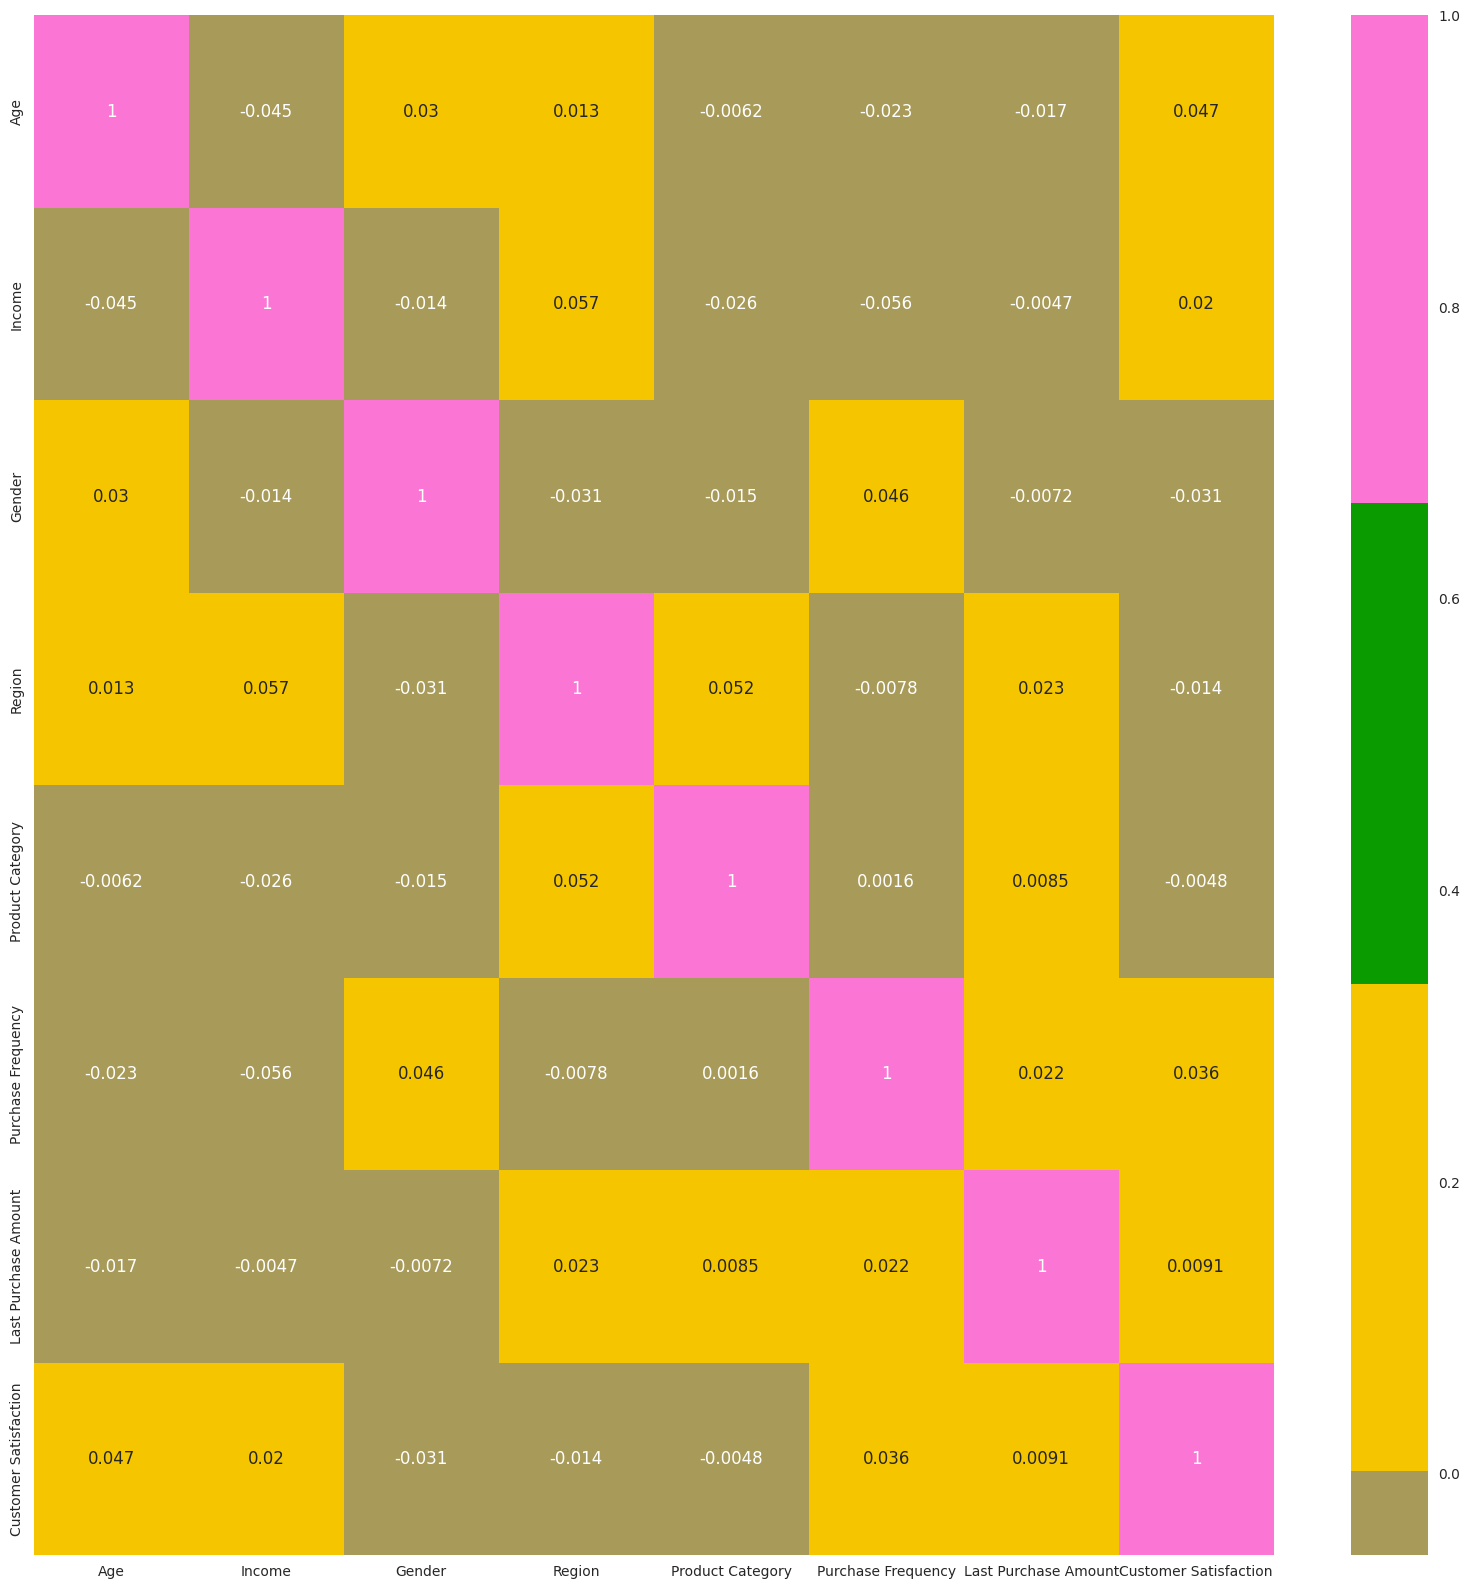

In [14]:
corrmat= data.corr()
plt.figure(figsize=(20,20))
cmap = colors.ListedColormap(["#32224c","#a53a06","#a89a59","#f5c600","#0a9b00","#fb75d5"])  
sns.heatmap(corrmat,annot=True,cmap=cmap,center=0)

**Data Preprocessing**

I have already converted the categorical features to numerical ones. I will now be scaling these features.

In [15]:
ds=data.copy()
scaler=StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [16]:
print("modified dataset : ")
scaled_ds.head()

modified dataset : 


,Age,Income,Gender,Region,Product Category,Purchase Frequency,Last Purchase Amount,Customer Satisfaction
0,-0.509012,-0.035221,1.241536,1.295527,-1.453516,-0.676501,-1.744977,-1.729743
1,0.819694,0.070870,1.241536,-0.502347,-0.022661,0.310749,-1.736123,1.127364
2,0.487518,0.858141,0.011135,-1.401284,-0.738088,-1.663751,-1.734540,1.281802
3,1.550482,0.514811,-1.219266,1.295527,-1.453516,1.298000,-1.730077,-1.420866
4,1.484047,-0.376986,-1.219266,0.396590,-0.022661,0.063937,-1.729358,0.123516


I will now be performing Dimensionality reduction. The dataset already contains a many dimensions. To reduce them, **i will be using PCA**
For this, i will be reducing the dimensions to 3.

In [17]:
pca=PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,884.0,2.411344e-17,1.056315,-2.889380,-0.739839,-0.024253,0.762651,3.046843
col2,884.0,-6.430251e-17,1.028652,-2.824863,-0.691408,-0.007785,0.689738,3.046442
col3,884.0,1.607563e-17,1.023456,-2.658723,-0.706184,-0.031127,0.702493,2.945730


A 3D projection of these three columns

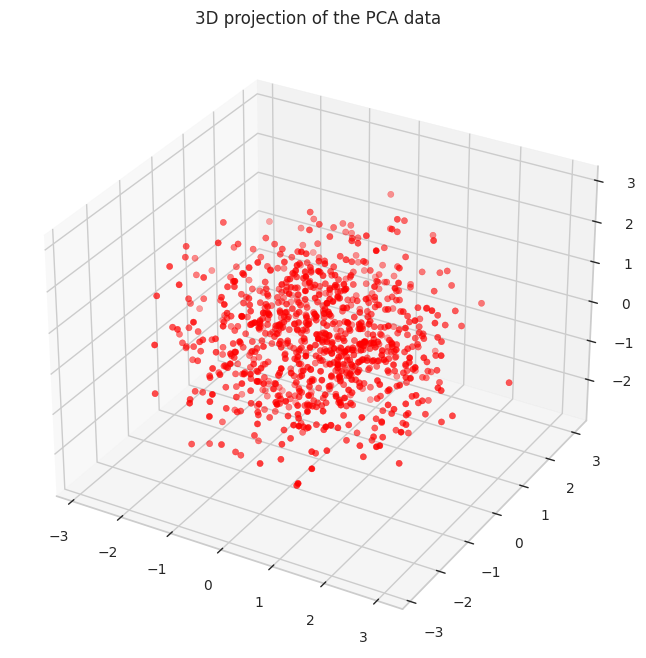

In [18]:
x=PCA_ds["col1"]
y=PCA_ds["col2"]
z=PCA_ds["col3"]
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="red", marker="o" )
ax.set_title("3D projection of the PCA data")
plt.show()

Now that i have reduced the dimensions. I will be performing clustering using **Agglomerative Clustering**
I will be using the elbow method to determine the number of clusters to be formed.

Number of clusters using the elbow method:


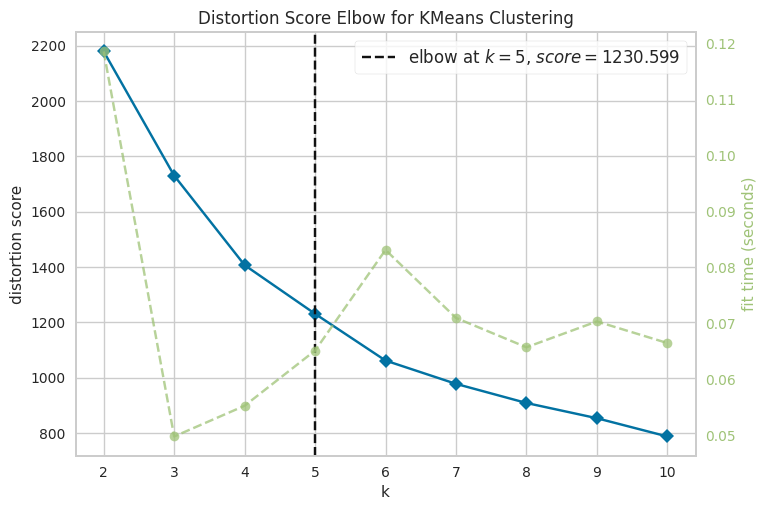

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
print('Number of clusters using the elbow method:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

This indicates that creating 5 clusters will be optimal for the dataset.

In [20]:
CL=AgglomerativeClustering(n_clusters=5)
yhat_CL=CL.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_CL
data["Clusters"]= yhat_CL

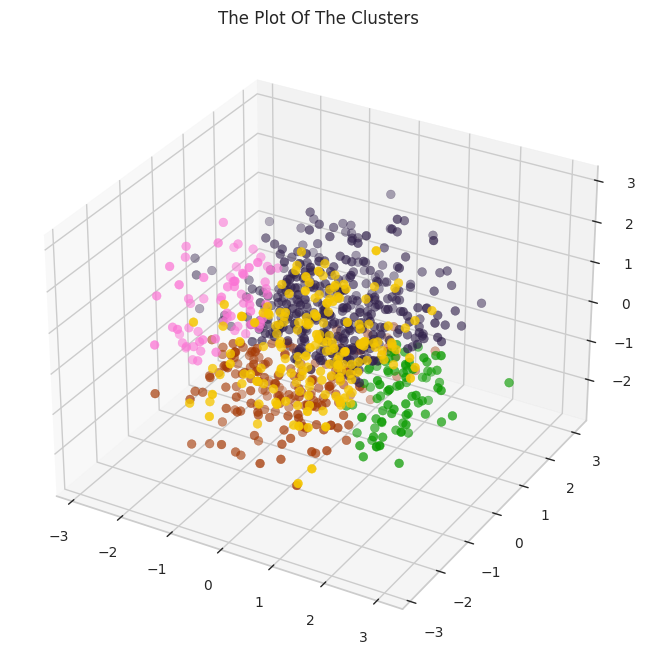

In [21]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

Evaluating these clusters.

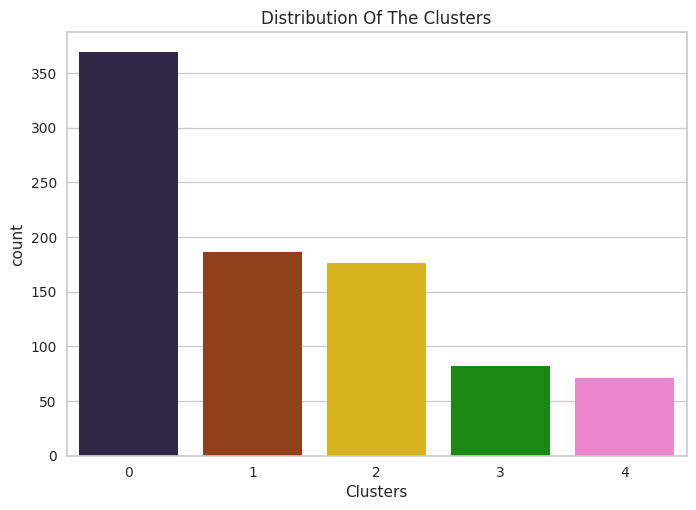

In [22]:
pal = ["#32224c","#a53a06","#f5c600","#0a9b00","#fb75d5"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

cluster 0 has most occurence while, then 1 and 2 are comparable and then 3 and 4 are comparable. 

In [23]:
A=["Age","Income","Gender","Region","Product Category","Purchase Frequency","Last Purchase Amount","Customer Satisfaction"]

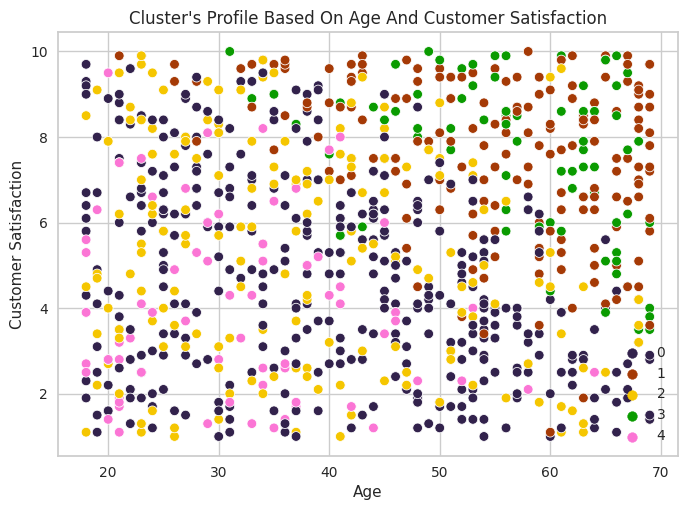

In [24]:
pl = sns.scatterplot(data = data,x=data["Age"], y=data["Customer Satisfaction"],hue=data["Clusters"], palette= pal)
pl.set_title(f"Cluster's Profile Based On Age And Customer Satisfaction")
plt.legend()
plt.show()
    

The dataset is very ambigous and does not follows any particular trend. However,it can be seen that yellow and light green clusters represent old people who tend to have a higher customer sastisfaction.
Pink represents young people who have low customer satisfaction.
While red and blue contains general people.

Now, let's look at the detailed distribution of clusters based on product category.

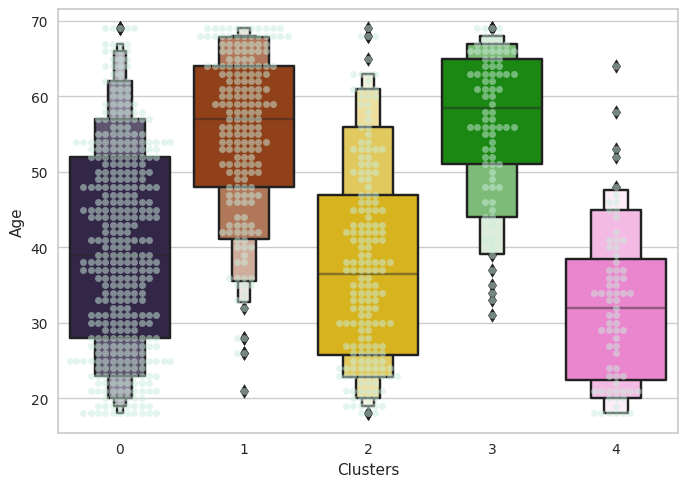

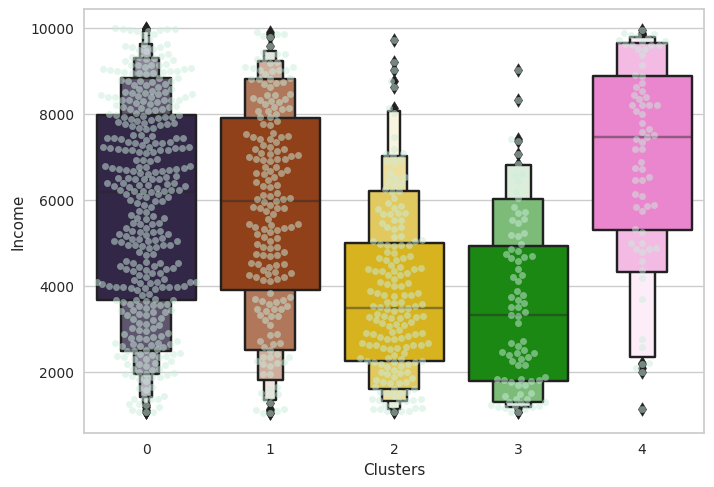

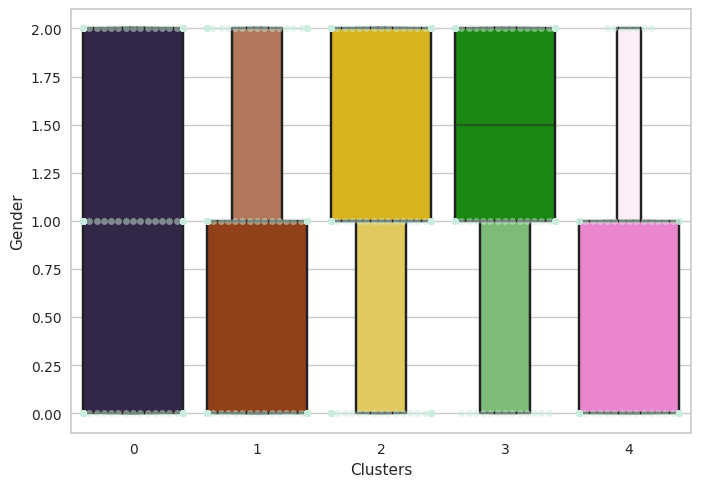

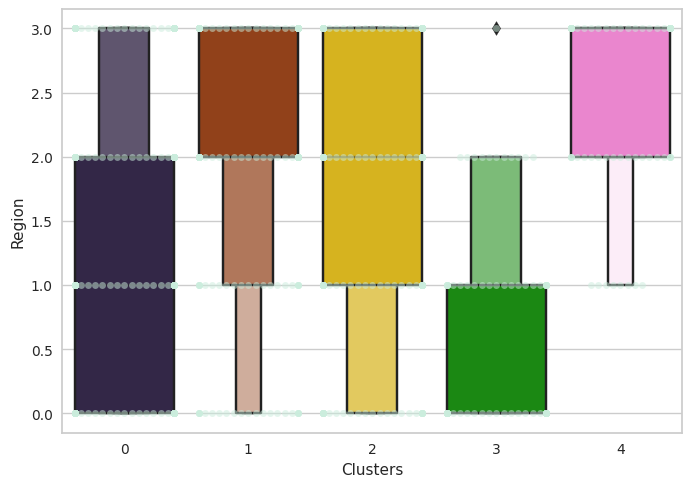

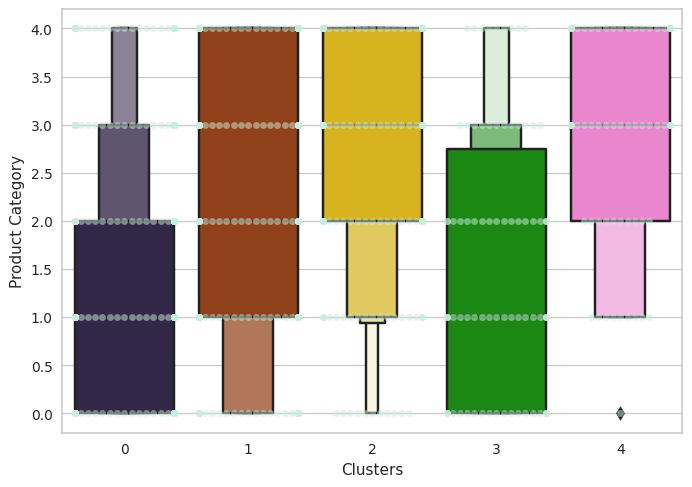

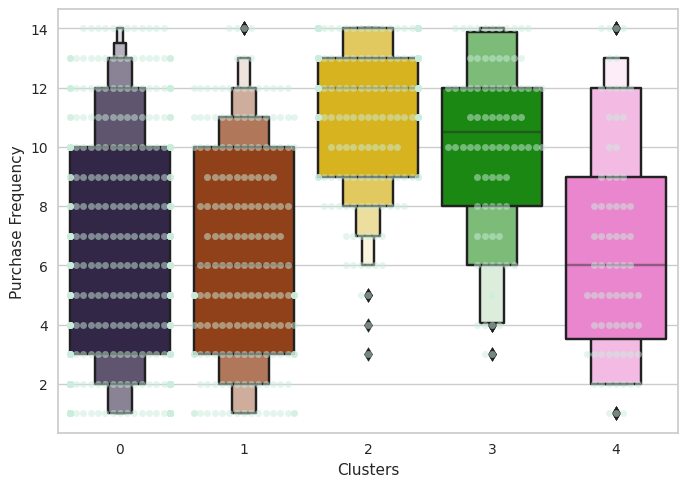

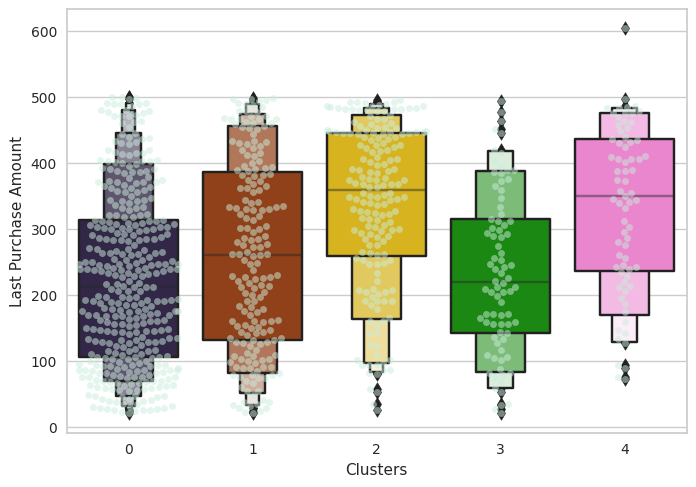

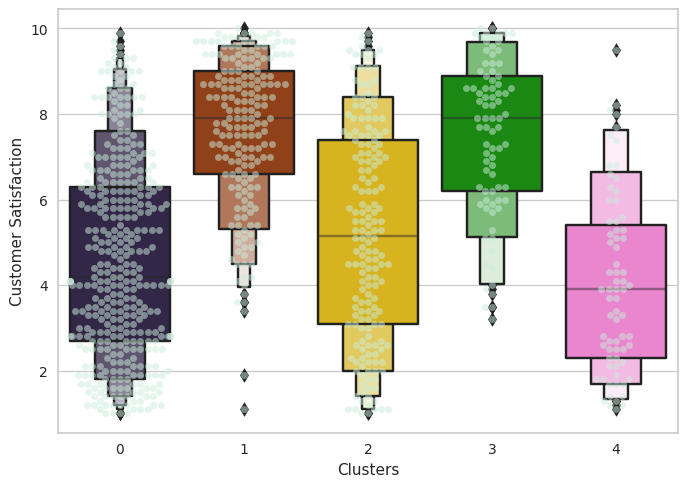

In [25]:
for i in range(len(A)) :
    plt.figure()
    pl=sns.swarmplot(x=data["Clusters"], y=data[A[i]], color= "#CBEDDD", alpha=0.5 )
    pl=sns.boxenplot(x=data["Clusters"], y=data[A[i]], palette=pal)
    plt.show()

After looking at the above distributions, a lot of information about the customer behavior can be deduced.
1. : Considering purchase frequency and last purchase amount, cluster 0 is our biggest customer. Followed by cluster 2 and 4.
2. : Considering Gender attributions, Old people above age 50 are more likely to be gender fluid. Young people below the age of 30 are mostly males or females.
3.  Old customers tend to give a higher customer sastisfaction as compared to young ones.
4. : Young customers with income greater than 5000 prefer living in region 2 (South) and 3 (West). Whereas old people with income less than 5000 prefer living in region 0(East) and 1(North).
5. : Young people tend to purchase products of category 2 (Groceries), 3 (Home and Living) and 4 (sports).

**Profiling** :
1. CLuster 0:
* Is the biggest customer among all the clusters.
* Contains people from all walks of life
* Customer satisfaction is most likely to be between 3 and 7.
2. Cluster 1:
* Tends to have a high last purchase amount and high frequency
* Has relatively lower income.
* Almost always purchases Groceries, Home and living or Sports items.
3. Cluster 2:
* Mostly Consists of people above the age of 50
* Higher Customer Satisfaction
* Biggest source of income after cluster 0
* Has people ranging from middle income category to lower upper income category.
4. Cluster 3:
* Consists of older people (above age 50) but with lower income.
* Lives in East or North region
* Consists of Gender Fluid people.
5. Cluster 4:
* Consists of young people below the age of 40
* Lower customer Satisfaction
* Has High income (above 5000) and lives in South and West Regions

**Conclusion** :
After looking through the data above, it is evident that the most valuable customer is someone who is above the age of 50. They are most likely to give a higher customer satisfaction, have higher frequency and  higher last purchase amount.